In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random

In [2]:
tf.random.set_seed(123456)

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
data_dir= "Input/Images/Images"

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 3444 files for training.


In [6]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 1476 files for validation.


In [7]:
class_names = train_dataset.class_names
print(class_names)

['glasses', 'no_glasses']


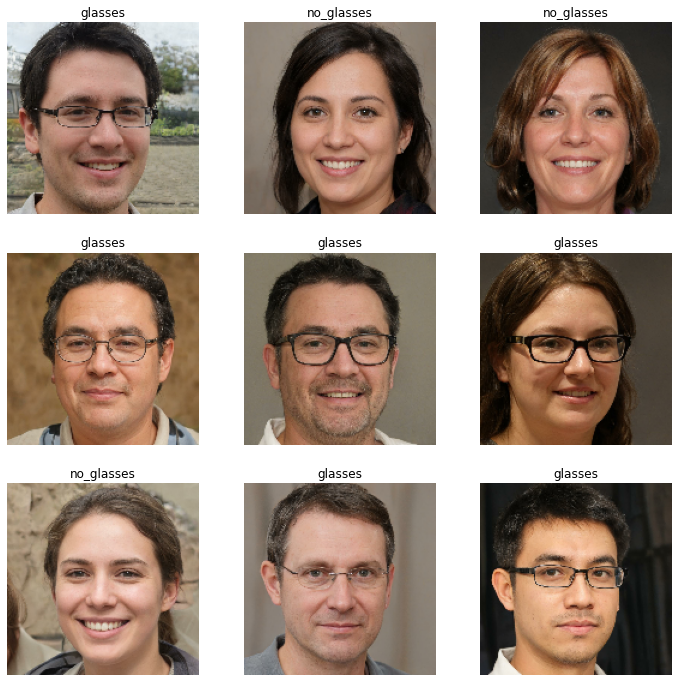

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 108
Number of validation batches: 38
Number of test batches: 9


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

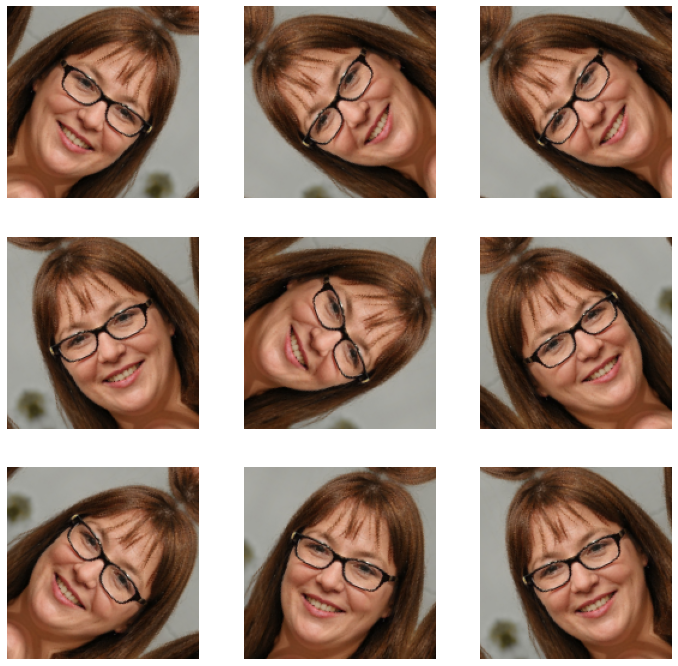

In [13]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

38/38 [==============================] - 2s 27ms/step - loss: 0.6121 - accuracy: 0.6271


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.61
initial accuracy: 0.63


In [27]:
model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset)

Epoch 1/10
108/108 [==============================] - 8s 56ms/step - loss: 0.6846 - accuracy: 0.6013 - val_loss: 0.5320 - val_accuracy: 0.6515
Epoch 2/10
108/108 [==============================] - 6s 54ms/step - loss: 0.5336 - accuracy: 0.7085 - val_loss: 0.4706 - val_accuracy: 0.7172
Epoch 3/10
108/108 [==============================] - 6s 55ms/step - loss: 0.4431 - accuracy: 0.7828 - val_loss: 0.4219 - val_accuracy: 0.7778
Epoch 4/10
108/108 [==============================] - 6s 57ms/step - loss: 0.3869 - accuracy: 0.8174 - val_loss: 0.3797 - val_accuracy: 0.8199
Epoch 5/10
108/108 [==============================] - 6s 55ms/step - loss: 0.3457 - accuracy: 0.8470 - val_loss: 0.3560 - val_accuracy: 0.8308
Epoch 6/10
108/108 [==============================] - 6s 58ms/step - loss: 0.3096 - accuracy: 0.8653 - val_loss: 0.3271 - val_accuracy: 0.8502
Epoch 7/10
108/108 [==============================] - 6s 55ms/step - loss: 0.2811 - accuracy: 0.8868 - val_loss: 0.3122 - val_accuracy: 0.8527

In [28]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

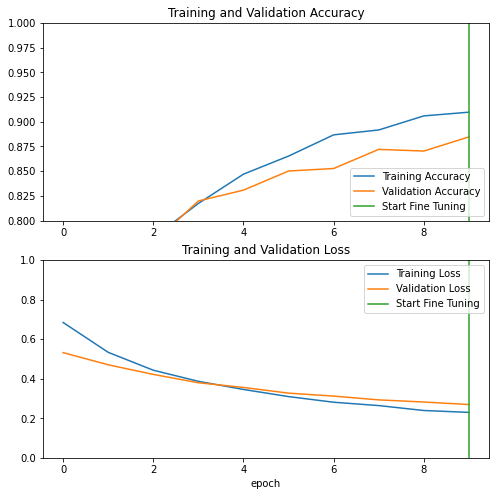

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

108/108 [==============================] - 3s 25ms/step - loss: 0.2549 - accuracy: 0.8789
Test accuracy : 0.8923611044883728
Train accuracy : 0.8789198398590088


In [31]:
base_model.trainable = True

In [32]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
len(model.trainable_variables)

56

In [35]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 10/15
108/108 [==============================] - 11s 72ms/step - loss: 0.0651 - accuracy: 0.9750 - val_loss: 0.0344 - val_accuracy: 0.9882
Epoch 11/15
108/108 [==============================] - 8s 68ms/step - loss: 0.0304 - accuracy: 0.9895 - val_loss: 0.0232 - val_accuracy: 0.9916
Epoch 12/15
108/108 [==============================] - 7s 66ms/step - loss: 0.0173 - accuracy: 0.9933 - val_loss: 0.0162 - val_accuracy: 0.9933
Epoch 13/15
108/108 [==============================] - 7s 66ms/step - loss: 0.0150 - accuracy: 0.9939 - val_loss: 0.0145 - val_accuracy: 0.9966
Epoch 14/15
108/108 [==============================] - 7s 67ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0142 - val_accuracy: 0.9958
Epoch 15/15
108/108 [==============================] - 7s 66ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0097 - val_accuracy: 0.9966


In [36]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

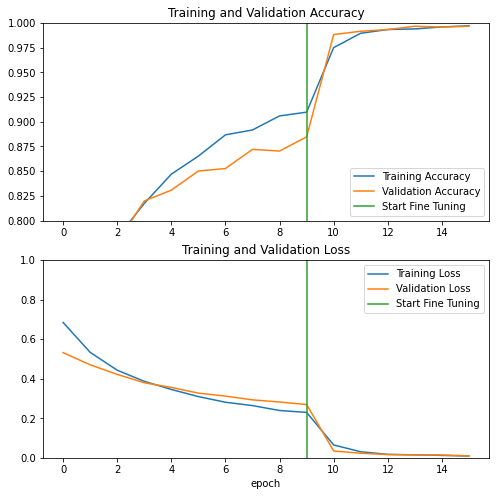

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

38/38 [==============================] - 1s 20ms/step - loss: 0.0148 - accuracy: 0.9958
Test accuracy : 1.0
Train accuracy : 0.9994192719459534
Validation accuracy : 0.9957912564277649


Predictions:
 [0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]
Labels:
 [0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]


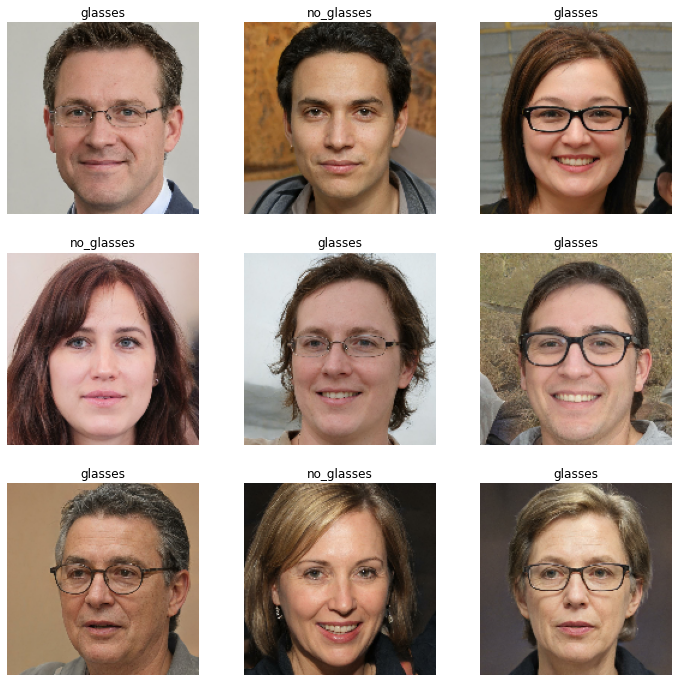

In [39]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")